In [1]:
import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal
import pickle
import sys
# Notebook needs to see the RKLM_Python module to load pickled class instances
sys.path.append('../RKLM_Python/')

(300, 10, 64, 64)
(300, 10, 64, 64)


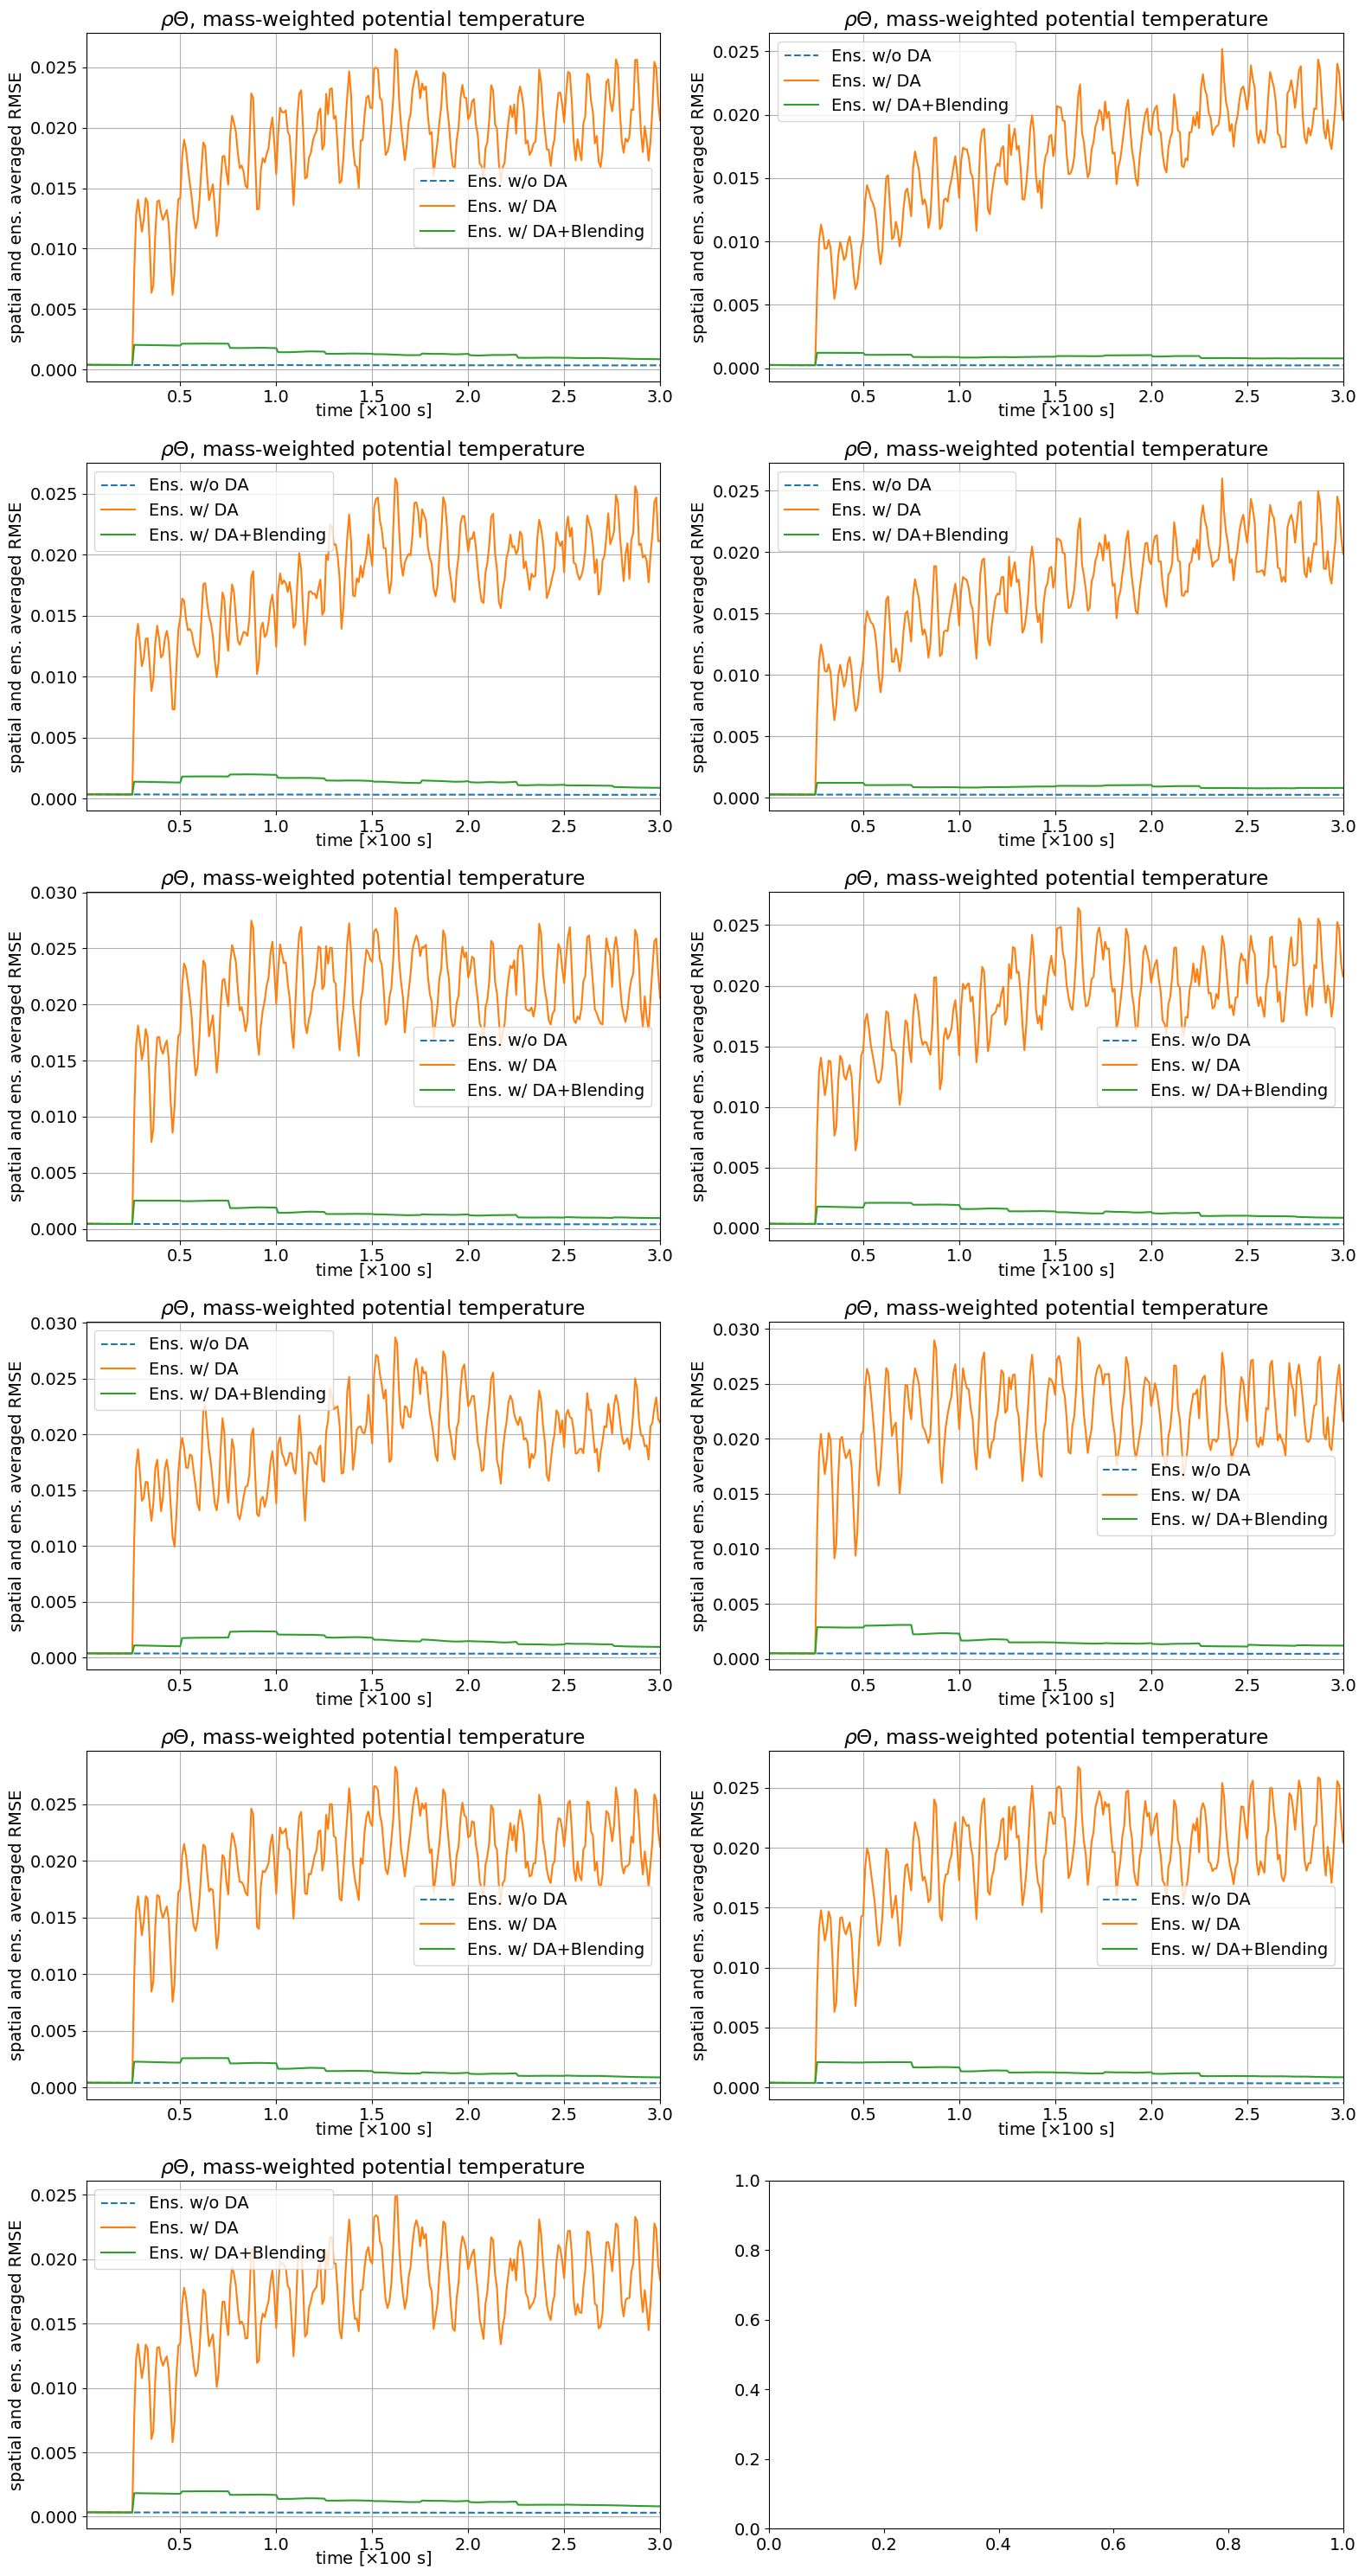

In [123]:
import matplotlib.pyplot as plt

base_fn = "output_swe_vortex"
directory = "output_swe_vortex"
py_directory = "../%s/" %directory

et = 3.0
Nx, Ny, Nz = 64, 1, 64
swe_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)

base_fn = "output_travelling_vortex"
directory = "output_travelling_vortex"
py_directory = "../%s/" %directory

Nx, Ny = 64, 64
euler_tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)

py_directory = "../%s/" %directory

plt.style.use('default')

N = 10
times = np.arange(0.0,3.01,0.01)[1:]

probe_idx = [32,32]

fn = 'effects_obs_covar_ensemble_spread'
title = ''

swe = True if 'swe' in base_fn else False
tc = swe_tc if swe else euler_tc
        
prt = utils.prt_time(debug=False)
if swe:
    attr_labels = pt.swe_labels()
    attributes = ['rho','p2_nodes','rhou','rhow']
    attributes = ['rho','rhou']
else:
    attr_labels = pt.labels()
    attributes = ['rhoY','p2_nodes','rhou','rhov']
    attributes = ['rhoY']

if len(attributes) == 2:
    fs = (16,6)
    nrows = 1
elif len(attributes) == 1:
    fs = (16,30)
    nrows = 5+1
else:
    fs = (16,14)
    nrows = 2
pl = pt.plotter_1d(figsize=fs,fontsize=14,ncols=2,nrows=nrows)

rmse_type = 'spatial'

typ = 'pos'
ens_34 = False

def get_ens(sfx,diff):
    ens = tc.get_ensemble(times, N, attribute, sfx, label_type='TIME', avg=False, diff=diff)[1:]
    if swe:
        ens = ens[:,:,0,:]
        if attribute is 'rho': ens *= 10.0
    return ens

for i,attribute in enumerate(attributes):
    diff = False if attribute == 'p2_nodes' else False
    gt = 'n' if attribute == 'p2_nodes' else 'c'
    
    ens_noda_suffix = 'pp_tra_ip_nonorm_ib-0'
    ens_noda_suffix = 'debug_%s_noda_ib-0' %typ
    ens_noda_label = 'Ens. w/o DA'
    ens_noda = get_ens(ens_noda_suffix, diff)
    
    obs_attrs = 'rhou_rhow' if swe else 'rhou_rhov'
    tags = 's10p'
    ens_1_suffix = 'wdawloc_%s_debug_letkf_%s_ib-0' %(obs_attrs,tags)
    ens_1_suffix = 'wdawloc_%s_debug_%s_%s_ib-0' %(obs_attrs,typ, tags)
    ens_1_label = r'EnDA'
    ens_1_label = r'Ens. w/ DA'
    
    ens_2_suffix = tc.cb_suffix(1,0, '%s' %(ens_1_suffix))
    ens_2_label = r'EnDAB'
    ens_2_label = r'Ens. w/ DA+Blending'

    ens_1 = get_ens(ens_1_suffix, diff)
    ens_2 = get_ens(ens_2_suffix, diff)
    
    if ens_34:
        ens_3_label = (ens_1_label)
        ens_4_label = (ens_2_label)
        ens_1_label += ' %s' %typ
        ens_2_label += ' %s' %typ
        
        obs_attrs = 'rhou_rhov'
        tags = 's10p'
        ens_3_suffix = 'wdawloc_%s_pp_tra_ip_nonorm_ib-0' %obs_attrs
        ens_3_suffix = 'wdawloc_%s_debug_pos_%s_ib-0' %(obs_attrs,tags)
        ens_4_suffix = tc.cb_suffix(1,0, '%s' %(ens_3_suffix))

        ens_3_label += ' pos'
        ens_4_label += ' pos'
        
        ens_3 = get_ens(ens_3_suffix, diff)
        ens_4 = get_ens(ens_4_suffix, diff)

    print(ens_2.shape)
    
    obs = tc.get_ensemble(times, 1, attribute, 'comp_1.0_pp_tra_truth_ip', label_type='TIME',avg=True, diff=diff)
    truth = tc.get_ensemble(times, 1, attribute, 'comp_1.0_pp_tra_truth_ip_ib-0', label_type='TIME',avg=True, diff=diff)
    truth_pos = tc.get_ensemble(times, 1, attribute, 'comp_1.0_pp_tra_truth_ip_ib-0', label_type='TIME',avg=True, diff=diff)
    if swe:
        truth = truth[:,:,0,:]
        if attribute is 'rho': truth *= 10.0
    
    print(ens_noda.shape)
    for nn in range(N+1):
        ax = pl.get_ax(nn)
        avg = False
        
        if nn == N:
            ens_noda_mem = ens_noda.mean(axis=1)
            ens_1_mem = ens_1.mean(axis=1)
            ens_2_mem = ens_2.mean(axis=1)
        else:
            ens_noda_mem = ens_noda[:,nn,...]#[np.newaxis,...]
            ens_1_mem = ens_1[:,nn,...]#[np.newaxis,...]
            ens_2_mem = ens_2[:,nn,...]#[np.newaxis,...]
        
        if rmse_type == 'spatial':
            diff_noda = tc.spatially_averaged_rmse(ens_noda_mem,truth,avg=avg,grid_type=gt)
            diff_ens_1 = tc.spatially_averaged_rmse(ens_1_mem,truth,avg=avg,grid_type=gt)
            diff_ens_2 = tc.spatially_averaged_rmse(ens_2_mem,truth,avg=avg,grid_type=gt)
            if ens_34:
                diff_ens_3 = tc.spatially_averaged_rmse(ens_3[nn],truth_pos,avg=avg,grid_type=gt)
                diff_ens_4 = tc.spatially_averaged_rmse(ens_4[nn],truth_pos,avg=avg,grid_type=gt)
            ax.set_ylabel('spatial and ens. averaged RMSE')
            if swe:
                ax.set_xlabel(r'time [$\times 1000$ s]', ha='center', va='center', labelpad=5)
            else:
                ax.set_xlabel(r'time [$\times 100$ s]', ha='center', va='center')
            rhoY_err = np.copy(diff_ens_1) if nn == N else None

        if diff == True: times = times[1:]
    
        ax.plot(times,diff_noda, '--', label=ens_noda_label)
        
        ax.plot(times,diff_ens_1, label=ens_1_label)
        ax.plot(times,diff_ens_2, label=ens_2_label)
        if ens_34:
            ax.plot(times,diff_ens_3, 'C1--', label=ens_3_label)
            ax.plot(times,diff_ens_4, 'C2--', label=ens_4_label)

        ax.set_title("%s" %attr_labels[attribute])
        ax.set_xlim([times[0],times[-1]])
        ax.grid()
        ax.legend()

    plt.tight_layout(rect=[-0.0, -0.0, 1.0, 1.0])
    
#     prt.prtt('plt')

plt.tight_layout()
lbl = 'swe' if swe else 'euler'
plt.show()

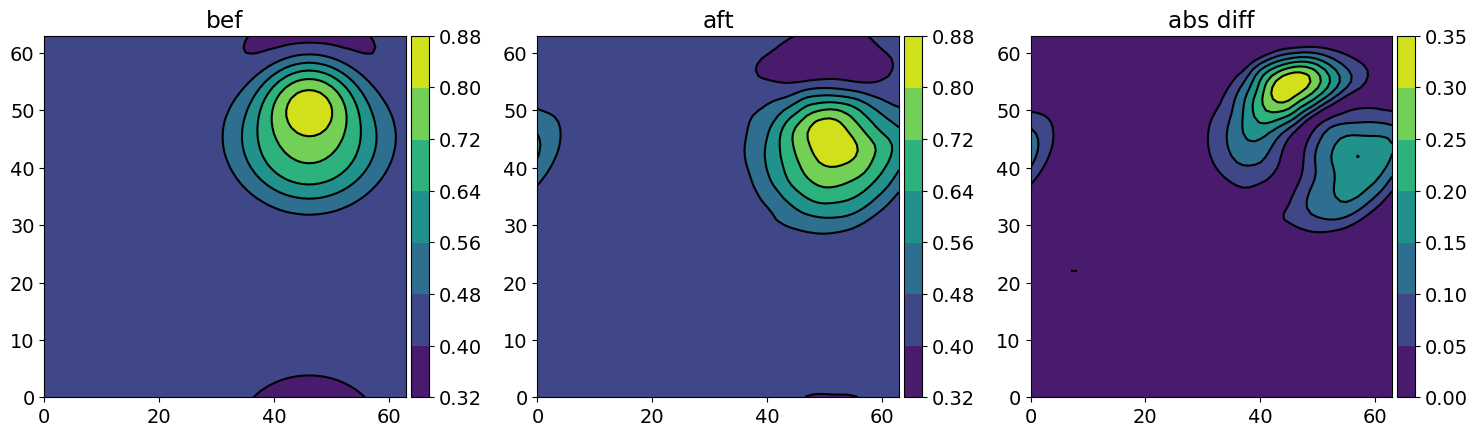

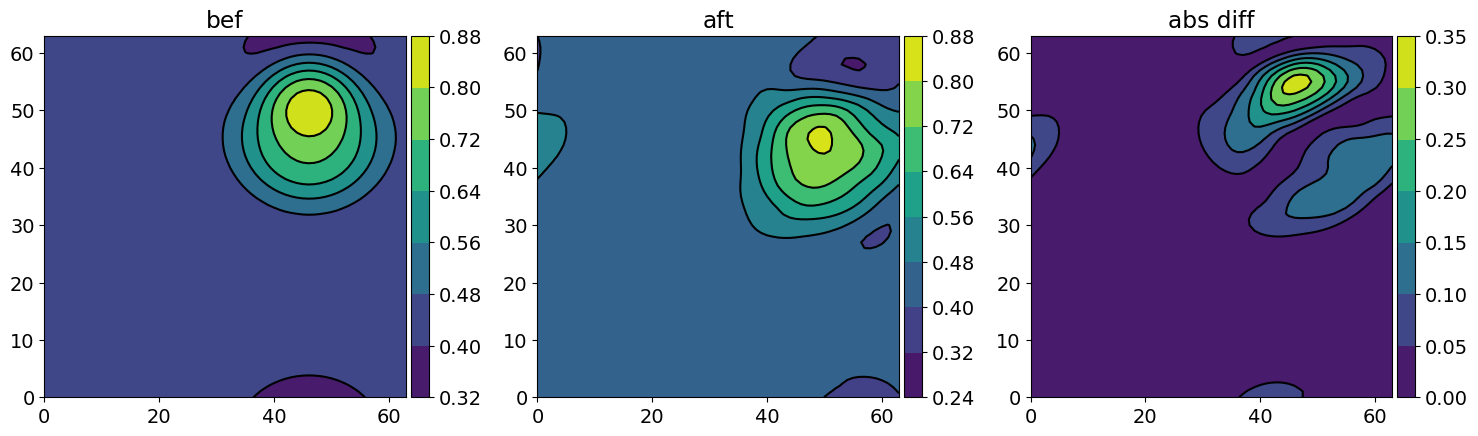

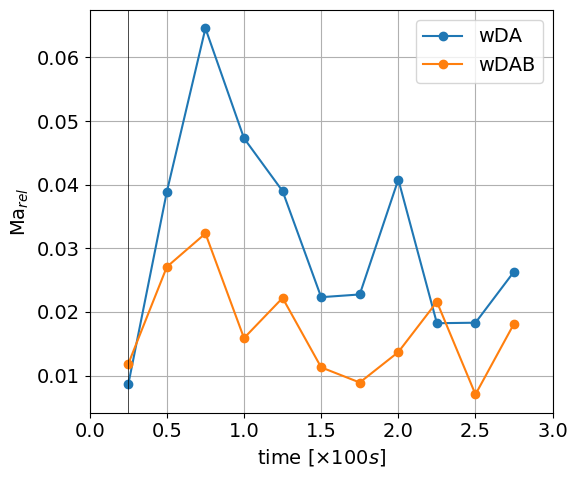

0.03155603160158929
0.01727511006795935


In [122]:
swe = False

attributes = ['rho','rhou','rhov']
et = 3.0
N = 10

if swe:
    base_fn = "output_swe_vortex"
    directory = "output_swe_vortex"
    py_directory = "../%s/" %directory

    Nx, Ny, Nz = 64, 1, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et,Nz=Nz)
else:
    base_fn = "output_travelling_vortex"
    directory = "output_travelling_vortex"
    py_directory = "../%s/" %directory

    Nx, Ny = 64, 64
    tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)


sfx0 = 'wdawloc_rhou_rhov_debug_pos_s10p_ib-0'
sfx1 = tc.cb_suffix(1,0, '%s' %(sfx0))
sfxes = [sfx0,sfx1]
times_bef = np.arange(0.0,3.25,0.25)[1:-1]
times_aft = 0.01 + times_bef
l_typ = 'TIME'
tag = tc.get_tag_dict()[9]

prt = utils.prt_time(debug=False)
attr_labels = pt.labels_increment()

fn_pickle = tc.get_filename(N,sfx1,format='dat')
path_pickle = tc.get_path(fn_pickle)

file = open(path_pickle,'rb')
ud = pickle.load(file)
file.close()

def get_ens(tc, sfx , diff, attribute):
    tag_aft = tc.get_tag_dict()[9]
    tag_bef = 'before_da'
    
    bef = get_ens_by_attr(times_bef, N, attributes, sfx, tag_bef)
    aft = get_ens_by_attr(times_aft, N, attributes, sfx, tag_aft)

    return bef, aft

class oo(object): None
    
def get_ens_by_attr(times, N, attributes, sfx, tag=tag):
    obj = oo()
    for attribute in attributes:
        ens = tc.get_ensemble(times, N, attribute, sfx, tag=tag)[1:]
        
#         print(ens.shape, tag)
        ens_cp = np.zeros_like(ens)
        for mm, mem in enumerate(ens):
            for at, at_t in enumerate(mem):
                ens_cp[mm,at] = at_t.T

        ens = np.copy(ens_cp)
        
        mean = np.mean(ens,axis=1)
#         ens = np.append(ens,mean[:,np.newaxis,...],axis=1)
        setattr(obj,attribute,ens)
    
    ens_u = getattr(obj,attributes[1]) / getattr(obj,'rho')
    ens_v = getattr(obj,attributes[2]) / getattr(obj,'rho')
    setattr(obj, 'u', ens_u)
    setattr(obj, 'v', ens_v)
    
    return obj

Ms = np.zeros((2,len(times_bef)))

calc_max = True
for ee, sfx in enumerate(sfxes):
    bef, aft = get_ens(euler_tc, sfx, diff, attribute)

    # get mean velocity difference
    mv, mu = np.zeros_like(times_bef), np.zeros_like(times_bef)
    mvs, mus = np.zeros((N)), np.zeros((N))
    bumax, bvmax = 0.0, 0.0
    for tt,time in enumerate(times_bef):
        bu,bv = bef.rhou[tt], bef.rhov[tt]
        au,av = aft.rhou[tt], aft.rhov[tt]
#         bu,bv = bef.u[tt], bef.v[tt]
#         au,av = aft.u[tt], aft.v[tt]
        
        bu, bv = bu / ud.rho_ref, bv / ud.rho_ref
        au, av = au / ud.rho_ref, av / ud.rho_ref

#         bum = np.abs(bu.max())
#         bvm = np.abs(bv.max())

        du = np.array([np.abs(aum - bum) for aum, bum in zip(au,bu)])
        dv = np.array([np.abs(avm - bvm) for avm, bvm in zip(av,bv)])
    
#         mus = np.array([np.abs(aum.max() - bum.max()) for aum, bum in zip(au,bu)])
#         mvs = np.array([np.abs(avm.max() - bvm.max()) for avm, bvm in zip(av,bv)])
        cnt = 0
        for aum, bum in zip(au,bu):
#             aum = np.abs(aum)
#             bum = np.abs(bum)
#             max_diff = np.abs(aum.max() - bum.max())
#             mus = max_diff
#             min_diff = np.abs(aum.min() - bum.min())
#             mus = max_diff + min_diff
            bef_range = bum.max() - bum.min()
            aft_range = aum.max() - aum.min()
            mus[cnt] = np.abs(aft_range - bef_range)
            cnt += 1
            
        cnt = 0
        for avm, bvm in zip(av,bv):
#             avm = np.abs(avm)
#             bvm = np.abs(bvm)
#             max_diff = np.abs(avm.max() - bvm.max())
#             mvs = max_diff
#             min_diff = np.abs(avm.min() - bvm.min())
#             mvs = max_diff + min_diff
            bef_range = bvm.max() - bvm.min()
            aft_range = avm.max() - avm.min()
            mvs[cnt] = np.abs(aft_range - bef_range)
            cnt += 1
            
#         print(mus)
            
        if tt == 0:
            for mm, mem_du in enumerate(du):
                if mm == 0:
#                     arr_lst = [[bef.rhou[tt][mm],'bef'],[aft.rhov[tt][mm],'aft'],[mem_du,'abs diff']]
                    arr_lst = [[bu[mm],'bef'],[au[mm],'aft'],[mem_du,'abs diff']]
                    ncolslen = 3
                    fs = (15,5)
                    pl = pt.plotter(arr_lst,ncols=ncolslen,figsize=fs,sharey=False)
                    _ = pl.plot(aspect='equal',method='contour')

        # calculate rel. Mach
        if calc_max:
#             mu[tt] = du.max() * ud.u_ref
#             mv[tt] = dv.max() * ud.u_ref
            mu[tt] = mus.mean() * ud.u_ref
            mv[tt] = mvs.mean() * ud.u_ref
#             bum *= ud.u_ref
#             bvm *= ud.u_ref
#             c = (bum**2 + bvm**2)**0.5 / np.sqrt(ud.Msq)
#             print(du.max(),dv.max(), (du.max()**2 + dv.max()**2)**0.5)
#         else:
#             mu[tt] = du.mean() * ud.u_ref
#             mv[tt] = dv.mean() * ud.u_ref

        c = ud.u_ref / np.sqrt(ud.Msq)

#         Ms[ee,tt] = (mu[tt]**2 + mv[tt]**2)**0.5 / c
        Ms[ee,tt] = (mu[tt] + mv[tt])*0.5 / c
    
# print(ud.Msq)
# print(np.sqrt(ud.Msq))
# print(Ms)


import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
# barPu = np.array(barPu) * 0.1
plt.plot(times_bef, Ms[0], '-o', label=r'wDA')
plt.plot(times_bef, Ms[1], '-o', label=r'wDAB')
# plt.plot(t_axs,barPv, label=r'$\bar{p}_{[v]}^*$')
plt.axvline(0.25, c='k', lw=0.5)
plt.xlim([0.0,3.0])
plt.xlabel(r'time $[\times 100s]$')
plt.ylabel(r'$\mathrm{Ma}_{rel}$')
plt.legend()
# plt.plot(barPuv)
plt.grid()
plt.tight_layout()
    
typ = 'pos' if 'pos' in sfx1 else 'neg'
cmax = 'max' if calc_max else 'mean'
# plt.savefig('relMa_%s_%s.pdf' %(typ,cmax),bbox_inches='tight')
plt.show()

print(Ms[0].mean())
print(Ms[1].mean())

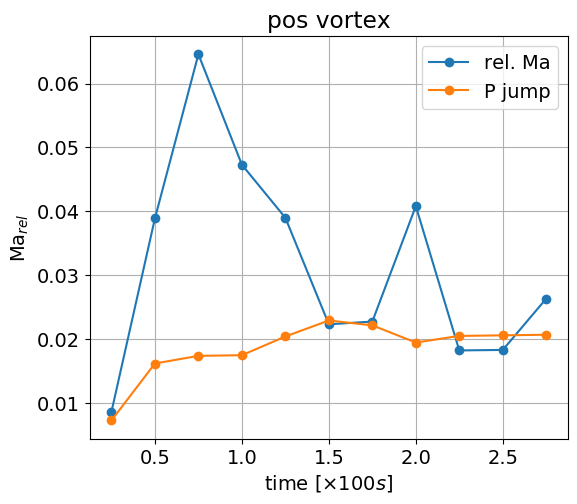

In [124]:
rhoY_error = np.copy(rhoY_err)

Hjump = rhoY_error[25:][::25]
# Hjump = np.append(Hjump,rhoY_error[-1])
Hjump00 = rhoY_error[24]
Hjump -= Hjump00

plt.figure(figsize=(6,5))
# barPu = np.array(barPu) * 0.1
t_axs = np.arange(0.25,3.25,0.25)[:-1]

plt.plot(t_axs, Ms[0], '-o', label=r'rel. Ma')
plt.plot(t_axs, Hjump, '-o', label=r'P jump')
# plt.plot(times, Ms[1], '-o', label=r'wDAB')s
# plt.plot(t_axs,barPv, label=r'$\bar{p}_{[v]}^*$')
# plt.axvline(0.25, c='k', lw=0.5)
# plt.xlim([0.0,3.0])
plt.xlabel(r'time $[\times 100s]$')
plt.ylabel(r'$\mathrm{Ma}_{rel}$')
plt.legend()
# plt.plot(barPuv)
plt.grid()
plt.tight_layout()
    
typ = 'pos' if 'pos' in sfx1 else 'neg'
plt.title('%s vortex' %typ )
cmax = 'max' if calc_max else 'mean'
plt.savefig('%s_relMa_P-jump.pdf' %(typ),bbox_inches='tight')
plt.show()